In [8]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.table import Table
import pymc3 as pm
import skymotion
import skymotionModified
import skyfield
import corner
from scipy import optimize
from astropy.coordinates import SkyCoord
from tqdm import tqdm

##set random seed
rand_seed = np.random.randint(0,2**32-1)
## note jet angle is defined opposite to convention 
mc_iterations = 100
print("Random seed:", rand_seed)
%matplotlib inline

Random seed: 1924830957


In [9]:
def mc_normal_sampler(mu, sigma):
    s = np.random.normal(mu, sigma, 10000)
    output = float(np.random.choice(s,1)[0])
    return output

def mc_trace_sampler(trace):
    output  = float(np.random.choice(trace,1)[0])
    return output

def perturbObsBasedOnErr(obs_alpha, obs_alpha_err, obs_delta, obs_delta_err):
    
    output_alpha = []
    output_delta = []
    
    for i in range(len(obs_alpha)):
        output_alpha.append(mc_normal_sampler(obs_alpha[i], obs_alpha_err[i]))
        output_delta.append(mc_normal_sampler(obs_delta[i], obs_delta_err[i]))
        
    return np.array(output_alpha), np.array(output_delta)

In [10]:
J1820_data = Table.read("./MAXIJ1820_positions_global_model.txt", format="ascii",names=['MJD','MJD_error','RA','RAs_er','Dec','Decs_er',
                         'Telescope','Band','Calib'])
J1820_calib = Table.read('MAXIJ1820_calib_data.txt',format='ascii')

In [11]:
J1820_data.add_column(Table.Column(data=np.full(len(J1820_data), np.nan), name='sys_ra'))
J1820_data.add_column(Table.Column(data=np.full(len(J1820_data), np.nan), name='sys_dec'))

J1820_data.add_column(Table.Column(data=np.full(len(J1820_data), np.nan), name='core_shift_ra'))
J1820_data.add_column(Table.Column(data=np.full(len(J1820_data), np.nan), name='core_shift_dec'))

J1820_data.add_column(Table.Column(data=np.full(len(J1820_data), np.nan), name='core_shift_ra_er'))
J1820_data.add_column(Table.Column(data=np.full(len(J1820_data), np.nan), name='core_shift_dec_er'))

for obs in J1820_data:
    obs_cal = J1820_calib[(J1820_calib['Calibrator'] == obs['Calib']) & (J1820_calib['Band'] == obs['Band'])]
    obs['core_shift_ra'] = obs_cal['offset_RA']
    obs['core_shift_dec'] = obs_cal['offset_dec']
    obs['core_shift_ra_er'] = obs_cal['offset_RA_er']
    obs['core_shift_dec_er'] = obs_cal['offset_dec_er']
    if obs['Telescope'] == 'VLBA':
        obs['sys_ra'] = np.sqrt(obs_cal['sys_VLBA_RA']**2 + obs_cal['Ion.sys.ra']**2)
        obs['sys_dec'] = np.sqrt(obs_cal['sys_VLBA_DEC']**2 + obs_cal['Ion.sys.dec']**2)
    elif obs['Telescope'] == 'EVN':
        obs['sys_ra'] = np.sqrt(obs_cal['sys_EVN_RA']**2 + obs_cal['Ion.sys.ra']**2)
        obs['sys_dec'] = np.sqrt(obs_cal['sys_EVN_DEC']**2 + obs_cal['Ion.sys.dec']**2)


In [12]:
J1820_time = J1820_data['MJD'].data
J1820_alpha = SkyCoord(J1820_data['RA'], J1820_data['Dec'], frame='icrs', unit=(u.hourangle, u.deg)).ra.degree
J1820_delta = SkyCoord(J1820_data['RA'], J1820_data['Dec'], frame='icrs', unit=(u.hourangle, u.deg)).dec.degree
## NOTE: we do not correct alpha for projection (cos(delta)) here and do that inside the MCMC fit
## this is beacuse it is more accurate to correct it during MCMC fit as we then update delta with the core shift as well

## core shifts are in *arcsecs* (NOT SECONDS OF ARC)
J1820_alpha += J1820_data['core_shift_ra'] * 1e-3 / 3600
J1820_delta += J1820_data['core_shift_dec'] * 1e-3 / 3600

J1820_alpha_err = ((J1820_data['RAs_er'].data/ 3600.0 * 15 * np.cos(np.radians(J1820_delta)))**2 + 
                            (J1820_data['sys_ra'].data*1e-6/3600)**2 + 
                            (J1820_data['core_shift_ra_er'].data*1e-6/3600)**2)**0.5

J1820_delta_err = ((J1820_data['Decs_er'].data/ 3600.0)**2 + 
                            (J1820_data['sys_dec'].data*1e-6/3600)**2 + 
                            (J1820_data['core_shift_dec_er'].data*1e-6/3600)**2)**0.5



In [13]:
J1820_mask = []

for freq in J1820_data['Band']:
    if freq == 5:
        J1820_mask.append(True)
    else:
        J1820_mask.append(False)
J1820_mask = np.array(J1820_mask)

In [14]:
with pm.Model() as uniformed_model:
    
    ra_0_guess = J1820_alpha.mean()
    dec_0_guess = J1820_delta.mean()

    
    alpha_0_prior = pm.Uniform('alpha 0', lower=ra_0_guess-0.2/3600, upper=ra_0_guess+0.2/3600)
    delta_0_prior = pm.Uniform('delta 0', lower=dec_0_guess-0.2/3600, upper=dec_0_guess+0.2/3600)
    
    parallax_prior = pm.Uniform('parallax', lower=0.1, upper=0.9)
    pm_alpha_prior = pm.Uniform('pm alpha', lower=-20.0, upper=20.0)
    pm_delta_prior = pm.Uniform('pm delta', lower=-20.0, upper=20.0)
    
    ra_core_shift_prior = pm.Uniform('ra shift', lower=-1, upper=1) ## in deg (to prevent chain failing)
    dec_core_shift_prior = pm.Uniform('dec shift', lower=-1, upper=1) ## in deg
    
    # orbital components:
    orb_Omega_prior = 0                                                                           # In degrees
    orb_a_prior = 0                                                                               # In milliarcsec
    orb_omega_prior = 0                                                                           # In degrees
    orb_i_prior = 0                                                                               # In degrees
    orb_T_0_prior = 0                                                                             # MJD
    orb_P_prior = 0                                                                               # in days
    orb_e_prior = 0                                                                               # unitless
    
    #####
    
    ## apply core shift to obs
    J1820_alpha_coreshifted = J1820_alpha + J1820_mask*ra_core_shift_prior
    J1820_delta_coreshifted = J1820_delta + J1820_mask*dec_core_shift_prior    
    # Expected values for RA and Dec:
    
    expected_ra, expected_dec = skymotionModified.total_motion(t = J1820_time,
                                             alpha = J1820_alpha_coreshifted,
                                             delta = J1820_delta_coreshifted,
                                             alpha_0 = alpha_0_prior,
                                             delta_0 = delta_0_prior,
                                             pm_alpha = pm_alpha_prior,
                                             pm_delta = pm_delta_prior,
                                             parallax = parallax_prior,
                                             orb_T_0 = orb_T_0_prior,
                                             orb_P = orb_P_prior,
                                             orb_e = orb_e_prior,
                                             orb_i = orb_i_prior,
                                             orb_omega = orb_omega_prior,
                                             orb_Omega = orb_Omega_prior,
                                             orb_a = orb_a_prior,
                                             binary_orbit = False)
    
    # Observed quantities:
    fitting_ra = pm.Normal('ra', mu = expected_ra, 
                           sd = J1820_alpha_err * np.cos(J1820_delta_coreshifted*np.pi/180), 
                           observed = J1820_alpha_coreshifted * np.cos(J1820_delta_coreshifted*np.pi/180))
    
    fitting_dec = pm.Normal('dec', mu = expected_dec, 
                            sd = J1820_delta_err, 
                            observed = J1820_delta_coreshifted)
    step_method = pm.NUTS()
    J1820_trace_2D = pm.sample(10000, chains=12, cores=12, tune=1000, random_seed=rand_seed, step=step_method)
    


/home/steve/miniconda3/envs/bh/lib/python3.7/site-packages/ipykernel_launcher.py:59: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [dec shift, ra shift, pm delta, pm alpha, parallax, delta 0, alpha 0]


Sampling 12 chains for 1_000 tune and 10_000 draw iterations (12_000 + 120_000 draws total) took 46 seconds.


In [15]:
print("The determined core-shift for J1820 offsets are")
print('ra  nu : {} mas'.format(np.median(J1820_trace_2D['ra shift'])*3.6e6))
print('ra  sd : {} mas'.format(np.std(J1820_trace_2D['ra shift'])*3.6e6))
print('dec nu : {} mas'.format(np.median(J1820_trace_2D['dec shift'])*3.6e6))
print('dec sd : {} mas'.format(np.std(J1820_trace_2D['dec shift'])*3.6e6))

The determined core-shift for J1820 offsets are
ra  nu : -0.03231253964397496 mas
ra  sd : 0.03964840739149028 mas
dec nu : 0.02805967098673534 mas
dec sd : 0.08457453711616704 mas


In [16]:
J1820_alpha_coreshifted = J1820_alpha + J1820_mask*np.median(J1820_trace_2D['ra shift'])
J1820_delta_coreshifted = J1820_delta + J1820_mask*np.median(J1820_trace_2D['dec shift'])
## add errors in quadrature
J1820_alpha_err_coreshifted = np.sqrt(J1820_alpha_err**2 + np.std(J1820_trace_2D['ra shift'])**2)
J1820_delta_err_coreshifted = np.sqrt(J1820_delta_err**2 + np.std(J1820_trace_2D['dec shift'])**2)

100%|██████████| 100/100 [00:00<00:00, 100.16it/s]


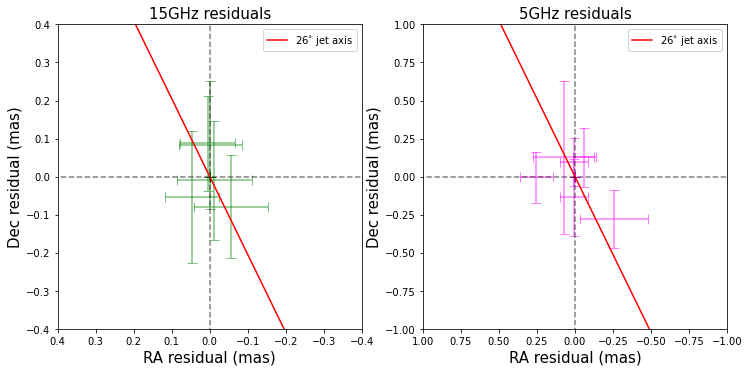

In [19]:
hfont = {'fontname':'Helvetica', 'size':15}
J1820_jet_angle = -26 ## it is 64 in literature
J1820_c_band_mask = np.invert(np.copy(J1820_mask))
J1820_ra_residual_trace = []
J1820_dec_residual_trace = []
J1820_ra_parallax_signal_trace = []
J1820_dec_parallax_signal_trace = []
J1820_perp_trace = []
J1820_para_trace = []

for i in tqdm(range(mc_iterations)):
    
    ## perturb observation
    J1820_alpha, J1820_delta = perturbObsBasedOnErr(J1820_alpha_coreshifted, J1820_alpha_err_coreshifted,\
                                                J1820_delta_coreshifted, J1820_delta_err_coreshifted)
    
    J1820_time = np.copy(J1820_time)
    
    ## perturb proper motion and parallax
    pm_alpha_deg = mc_trace_sampler(J1820_trace_2D['pm alpha']) / 3.6e6 / 365.25    
    pm_delta_deg = mc_trace_sampler(J1820_trace_2D['pm delta']) / 3.6e6 / 365.25    
    parallax_deg = mc_trace_sampler(J1820_trace_2D['parallax']) / 3.6e6
    alpha_0 = mc_trace_sampler(J1820_trace_2D['alpha 0'])
    delta_0 = mc_trace_sampler(J1820_trace_2D['delta 0'])
    
    ## compute proper motion and residuals
    frac_alpha, frac_delta = skymotion.frac_parallax(J1820_time, J1820_alpha, J1820_delta)
    ref_t = skymotion.t_0(J1820_time)
    fit_ra_proper = alpha_0 * np.cos(np.radians(J1820_delta)) + (pm_alpha_deg * (J1820_time - ref_t))
    fit_dec_proper = delta_0 + (pm_delta_deg * (J1820_time - ref_t))
    fit_ra = fit_ra_proper + frac_alpha * parallax_deg
    fit_dec = fit_dec_proper + frac_delta * parallax_deg
    
    J1820_ra_parallax_signal_trace.append(J1820_alpha* np.cos(np.radians(J1820_delta)) - fit_ra_proper)
    J1820_dec_parallax_signal_trace.append(J1820_delta - fit_dec_proper)
    J1820_ra_residual_trace.append(J1820_alpha* np.cos(np.radians(J1820_delta)) - fit_ra)
    J1820_dec_residual_trace.append(J1820_delta - fit_dec)
    
    
    

time_array = np.linspace(np.min(J1820_time)-50, np.max(J1820_time)+50, 200)

frac_alpha, frac_delta = skymotion.frac_parallax(time_array, np.mean(J1820_trace_2D['alpha 0']), \
                                                 np.mean(J1820_trace_2D['delta 0']) )

parallax_deg = np.mean(J1820_trace_2D['parallax'])



fig = plt.figure(figsize=(12,6))



ax1 = fig.add_subplot(121)
ax1.errorbar(np.median(J1820_ra_residual_trace, axis=0)*3.6e6*J1820_c_band_mask, np.median(J1820_dec_residual_trace, axis=0)*3.6e6*J1820_c_band_mask,\
             xerr=np.std(J1820_ra_residual_trace, axis=0)*3.6e6*J1820_c_band_mask, yerr=np.std(J1820_dec_residual_trace, axis=0)*3.6e6*J1820_c_band_mask,\
             fmt=' ', capsize=5,color="green", alpha=0.5)


x_array = np.linspace(-3, 3, 10)
y_array = x_array*np.tan(np.radians(J1820_jet_angle + 90))
ax1.plot(x_array, y_array, color="red", label=r'$26^{\circ}$ jet axis')
ax1.set_title("15GHz residuals",**hfont)
ax1.set_xlabel("RA residual (mas)",**hfont)
ax1.set_ylabel("Dec residual (mas)",**hfont)
ax1.set_xlim(0.4, -0.4)
ax1.set_ylim(-0.4, 0.4)
ax1.legend()
ax1.hlines(0, -4, 4, color='black', linestyle='dashed', alpha=0.5)
ax1.vlines(0, -4, 4, color='black', linestyle='dashed', alpha=0.5)



ax2 = fig.add_subplot(122)
ax2.errorbar(np.median(J1820_ra_residual_trace, axis=0)*3.6e6*J1820_mask, np.median(J1820_dec_residual_trace, axis=0)*3.6e6*J1820_mask,\
             xerr=np.std(J1820_ra_residual_trace, axis=0)*3.6e6*J1820_mask, yerr=np.std(J1820_dec_residual_trace, axis=0)*3.6e6*J1820_mask,\
             fmt=' ', capsize=5,color="magenta", alpha=0.5)


x_array = np.linspace(-15, 15, 10)
y_array = x_array*np.tan(np.radians(J1820_jet_angle + 90))
ax2.plot(x_array, y_array, color="red", label=r'$26^{\circ}$ jet axis')
ax2.set_title("5GHz residuals",**hfont)
ax2.set_xlabel("RA residual (mas)",**hfont)
ax2.set_ylabel("Dec residual (mas)",**hfont)
ax2.legend()
ax2.hlines(0, -20, 20, color='black', linestyle='dashed', alpha=0.5)
ax2.vlines(0, -20, 20, color='black', linestyle='dashed', alpha=0.5)
ax2.legend()

ax2.set_xlim(1, -1)
ax2.set_ylim(-1, 1)


ax1.set_aspect('equal')
ax2.set_aspect('equal')




plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.savefig('18202Dresiduals.png')